# Kaggle Login + Data Loading

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login() # dffe78a4a0967a0f1e81b3c86300e518


Kaggle credentials set.
Kaggle credentials successfully validated.


In [ ]:
import glob
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

artworks_artist_classification_soi_1010_2024_path = kagglehub.competition_download('artworks-artist-classification-soi-1010-2024')

print('Data source import complete.')


100%|██████████| 1.03G/1.03G [00:06<00:00, 158MB/s]

Extracting files...


Data source import complete.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
li = []
for dirname, _, filenames in os.walk(artworks_artist_classification_soi_1010_2024_path):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        li.append(os.path.join(dirname, filename))
for i in range(10):
  print(li[i])

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/root/.cache/kagglehub/competitions/artworks-artist-classification-soi-1010-2024/test.csv
/root/.cache/kagglehub/competitions/artworks-artist-classification-soi-1010-2024/sample_submission.csv
/root/.cache/kagglehub/competitions/artworks-artist-classification-soi-1010-2024/train.csv
/root/.cache/kagglehub/competitions/artworks-artist-classification-soi-1010-2024/train/train/lth.jpg
/root/.cache/kagglehub/competitions/artworks-artist-classification-soi-1010-2024/train/train/vcw.jpg
/root/.cache/kagglehub/competitions/artworks-artist-classification-soi-1010-2024/train/train/vue.jpg
/root/.cache/kagglehub/competitions/artworks-artist-classification-soi-1010-2024/train/train/gyv.jpg
/root/.cache/kagglehub/competitions/artworks-artist-classification-soi-1010-2024/train/train/xyv.jpg
/root/.cache/kagglehub/competitions/artworks-artist-classification-soi-1010-2024/train/train/wqy.jpg
/root/.cache/kagglehub/competitions/artworks-artist-classification-soi-1010-2024/train/train/exd.jpg


In [ ]:
artworks_artist_classification_soi_1010_2024_path

'/root/.cache/kagglehub/competitions/artworks-artist-classification-soi-1010-2024'

# Creating Custom Dataset

## Data Inspection

In [ ]:
class CustomDataset(Dataset):
  def __init__(self, path, transform=None, train=True):
    self.path = path
    self.transform = transform
    self.train = train
    self.class_cnt = {}

    if train:
      # Load train dataset
      self.label_map = pd.read_csv(os.path.join(path, 'train.csv'))
      self.img_list = glob.glob(os.path.join(path, 'train', 'train', '*.jpg'))
      self.gt_string = list(self.label_map['artist'].unique()) # 실제 artist 이름 -> train_target 값을 idx로 사용하면 나옴

      # Class-wise data count
      for x in self.gt_string:
        self.class_cnt[x] = self.label_map.groupby('artist').count().loc[x].values[0]

      self.trainset = []

      for img_path in self.img_list:
        img_id = img_path[-7:-4]
        temp = self.label_map[self.label_map['id'] == img_id]
        artist = temp['artist'].values[0]
        idx = self.gt_string.index(artist)

        img = Image.open(img_path).convert("RGB")

        self.trainset.append([img, idx])

    else:
      # Load test dataset
      self.testset = []
      self.label_map = pd.read_csv(os.path.join(path, 'test.csv'))
      self.img_list = glob.glob(os.path.join(path, 'test', 'test', '*.jpg'))

      for img_path in self.img_list:
        img = Image.open(img_path).convert("RGB")
        self.testset.append([img, img_path])

  def __len__(self):
    if self.train:
      return len(self.trainset)
    else:
      return len(self.img_list)

  def __getitem__(self, idx):
    if self.train:
      img, label = self.trainset[idx]
      img = self.transform(img)

      return img, label
    else:
      img, img_path = self.testset[idx]
      img = self.transform(img)

      return img, img_path

In [ ]:
# create data for inspection
trainset = CustomDataset(artworks_artist_classification_soi_1010_2024_path, transform = None, train=True)
test_data = CustomDataset(artworks_artist_classification_soi_1010_2024_path,  transform = None, train=False)

(3826, '/root/.cache/kagglehub/competitions/artworks-artist-classification-soi-1010-2024/train/train/ndz.jpg')
(226, '/root/.cache/kagglehub/competitions/artworks-artist-classification-soi-1010-2024/train/train/neb.jpg')
(4096, '/root/.cache/kagglehub/competitions/artworks-artist-classification-soi-1010-2024/train/train/ccz.jpg')
(204, '/root/.cache/kagglehub/competitions/artworks-artist-classification-soi-1010-2024/train/train/lmy.jpg')
(11386176, '/root/.cache/kagglehub/competitions/artworks-artist-classification-soi-1010-2024/train/train/ndz.jpg')
(55593, '/root/.cache/kagglehub/competitions/artworks-artist-classification-soi-1010-2024/train/train/ccw.jpg')


(-0.5, 212.5, 260.5, -0.5)

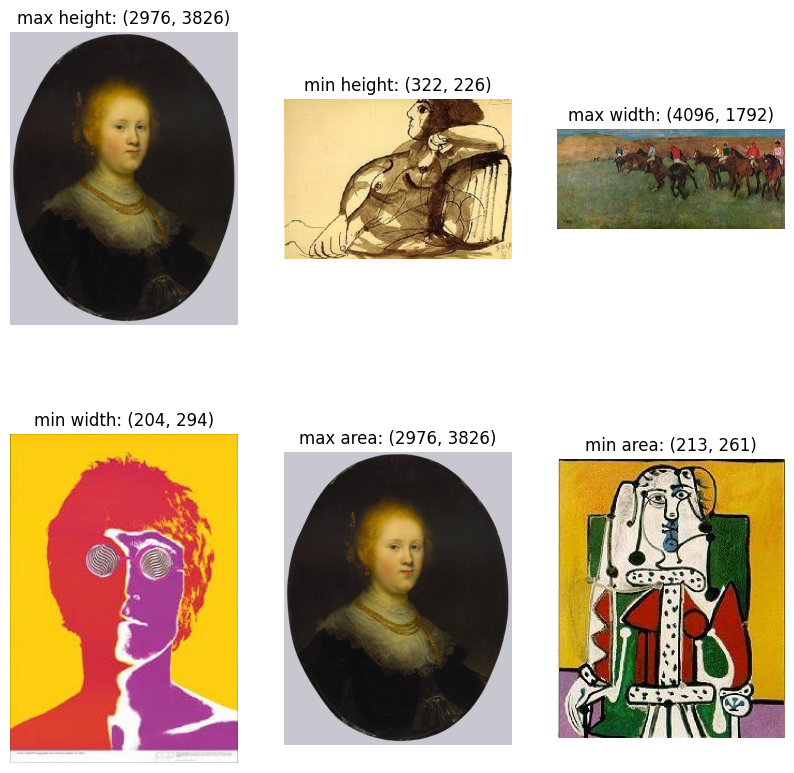

In [ ]:
width_li = []
height_li = []
area_li = []
for i in range(len(trainset.img_list)):
  img = Image.open(trainset.img_list[i])
  width, height = img.size
  width_li.append((width, trainset.img_list[i]))
  height_li.append((height, trainset.img_list[i]))
  area_li.append((width*height, trainset.img_list[i]))

max_height = max(height_li)
min_height = min(height_li)
max_width = max(width_li)
min_width = min(width_li)
max_area = max(area_li)
min_area = min(area_li)

print(max_height)
print(min_height)
print(max_width)
print(min_width)
print(max_area)
print(min_area)

img_max_height = Image.open(max_height[1])
img_min_height = Image.open(min_height[1])
img_max_width = Image.open(max_width[1])
img_min_width = Image.open(min_width[1])
img_max_area = Image.open(max_area[1])
img_min_area = Image.open(min_area[1])

plt.figure(figsize=(10, 10))

plt.subplot(2, 3, 1)
plt.imshow(img_max_height)
plt.title("max height: {}".format(img_max_height.size))
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(img_min_height)
plt.title("min height: {}".format(img_min_height.size))
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(img_max_width)
plt.title("max width: {}".format(img_max_width.size))
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(img_min_width)
plt.title("min width: {}".format(img_min_width.size))
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(img_max_area)
plt.title("max area: {}".format(img_max_area.size))
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(img_min_area)
plt.title("min area: {}".format(img_min_area.size))
plt.axis('off')

In [ ]:
transform_ = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [ ]:
# create data with transforms
trainset = CustomDataset(artworks_artist_classification_soi_1010_2024_path, transform = transform_, train=True)
test_data = CustomDataset(artworks_artist_classification_soi_1010_2024_path,  transform = transform_, train=False)

## Stratified Random Split - train_data, val_data

In [ ]:
from torch.utils.data import Subset
print(trainset.class_cnt)
total = len(trainset)

train_size = int(0.9 * len(trainset)) # train val ratio
val_size = len(trainset) - train_size
train_idx = [i for i in range(len(trainset))]
val_idx = []
print(len(train_idx))

{'Diego Velazquez': 71, 'Vincent van Gogh': 560, 'Claude Monet': 55, 'Edgar Degas': 443, 'Hieronymus Bosch': 105, 'Pierre-Auguste Renoir': 210, 'Rene Magritte': 121, 'Peter Paul Rubens': 83, 'Caravaggio': 30, 'Alfred Sisley': 147, 'Edouard Manet': 51, 'Rembrandt': 161, 'Pablo Picasso': 274, 'Titian': 153, 'Mikhail Vrubel': 106, 'Leonardo da Vinci': 96, 'Kazimir Malevich': 82, 'Andy Warhol': 118, 'Francisco Goya': 176, 'Vasiliy Kandinskiy': 53, 'Gustav Klimt': 65, 'Amedeo Modigliani': 121, 'Henri Rousseau': 48, 'Salvador Dali': 88, 'Pieter Bruegel': 79, 'Albrecht Du rer': 201, 'Paul Gauguin': 195, 'Sandro Botticelli': 111, 'Piet Mondrian': 51, 'Paul Klee': 124, 'William Turner': 41, 'Marc Chagall': 156, 'Jan van Eyck': 61, 'Henri Matisse': 111, 'El Greco': 57, 'Gustave Courbet': 37, 'Andrei Rublev': 70, 'Jackson Pollock': 20, 'Edvard Munch': 39, 'Camille Pissarro': 58, 'Raphael': 68, 'Henri de Toulouse-Lautrec': 57, 'Eugene Delacroix': 19, 'Joan Miro': 69, 'Giotto di Bondone': 64, 'Dieg

In [ ]:
label_indices = {i: [] for i in range(50)}
for idx, (data, label) in enumerate(trainset):
    label_indices[label].append(idx)

val_idx = []
train_idx = set(range(len(trainset)))

for label, indices in label_indices.items():
  total = len(indices)
  val_count = int(total / len(trainset) * val_size)
  selected_indices = torch.randperm(len(indices))[:val_count]
  selected = [indices[idx] for idx in selected_indices]
  val_idx.extend(selected)
  train_idx.difference_update(selected)

train_idx = list(train_idx)

# Validation check
if any(x in train_idx for x in val_idx):
    print("error")

In [ ]:
# stratified random split
train_data = Subset(trainset, train_idx)
val_data = Subset(trainset, val_idx)

In [ ]:
print(len(train_data))
print(len(val_data))

4801
510


Text(0.5, 1.0, 'Number of Image in Validation data after stratified random split')

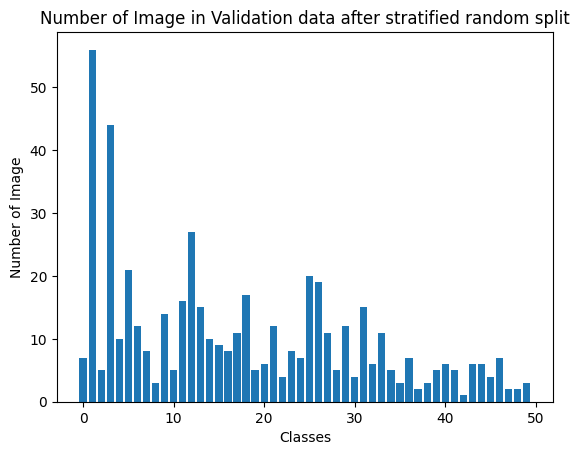

In [ ]:
# 해결됨! -> validation check
label_cnt_val = {}
for i in range(len(val_data)):
  data, label = val_data[i]
  if label not in label_cnt_val:
    label_cnt_val[label] = 0
  label_cnt_val[label] += 1

plt.bar(label_cnt_val.keys(), label_cnt_val.values())

plt.xlabel('Classes')
plt.ylabel('Number of Image')
plt.title('Number of Image in Validation data after stratified random split')


## Apply Transforms - Normalization and data augmentation

In [ ]:
# train_data에 normalization 할 값 구하기
# 채널별 평균과 표준편차 계산
mean = torch.zeros(3)
std = torch.zeros(3)
for i in range(len(train_data)):
  mean += train_data[i][0].mean(dim=(1, 2))
  std += train_data[i][0].std(dim=(1, 2))

print("Mean:", mean/len(train_data))
print("Std:", std/len(train_data))

Mean: tensor([0.5038, 0.4455, 0.3720])
Std: tensor([0.2081, 0.1936, 0.1767])


In [ ]:
# transforms 만들기
test_val_transform = transforms.Compose([
    transforms.Normalize(mean=mean/len(train_data), std=std/len(train_data)),
])

train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(50),
    transforms.RandomVerticalFlip(p=0.4),
    transforms.RandomRotation(50),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    #transforms.RandomPerspective(distortion_scale=0.1, p=0.5),   # creates some distorition
    transforms.ToTensor(),
    transforms.Normalize(mean=mean/len(train_data), std=std/len(train_data)),
])

# Data Imbalance Problem

## 0. custom dataset for transforms + data augmentation

In [ ]:
class TransformImbalanced(Dataset):
    def __init__(self, subset, transform, criterion = criteria, train=False, val=False, test=False, aug=False):
      self.subset = subset
      self.transform = transform
      self.train = train
      self.val = val
      self.test = test
      self.criterion = criterion
      self.aug = aug

      self.aug_li = []  # augmented list
      self.train_li = []  # train list
      self.remainder = {}
      self.name_cnt = {}  # count ++
      self.class_cnt = {}  # calculated count

      if self.train:
        if self.aug:
          for _, label in subset:
            if label not in self.class_cnt:
              self.class_cnt[label] = 0
            self.class_cnt[label] += 1

          for data, label in self.subset:
            count = self.class_cnt[label]
            artist_name = self.subset.dataset.gt_string[label]

            if artist_name not in self.name_cnt:
              self.name_cnt[artist_name] = 0
            else:
              self.name_cnt[artist_name] += 1

            # Undersampling
            if self.name_cnt[artist_name] >= self.criterion:
              continue
            self.train_li.append([data, label])

            if artist_name not in self.remainder:
              self.remainder[artist_name] = (self.criterion - count) % count if count < self.criterion else 0
            multiple = (self.criterion - count) // count if count < self.criterion else 0

            # Oversampling multiple times
            for _ in range(multiple):
              self.aug_li.append([data, label])

            # Oversample once more if remainder > 0
            if self.remainder[artist_name] > 0:
              self.aug_li.append([data, label])
              self.remainder[artist_name] -= 1
        else:
          for data, label in self.subset:
            self.train_li.append([data, label])

      elif self.val or self.test:
        self.test_val_li = []
        for data, label in self.subset:
          self.test_val_li.append([data, label])

    def __len__(self):
      if self.train and self.aug:
        return len(self.train_li) + len(self.aug_li)
      elif self.train:
        return len(self.train_li)
      elif self.val or self.test:
        return len(self.test_val_li)

    def __getitem__(self, idx):
      if self.train:
        if idx < len(self.train_li):
          x, y = self.train_li[idx]
          x_ = self.transform(x)
          return x_, y
        elif self.aug:
          idx -= len(self.train_li)
          x, y = self.aug_li[idx]
          x_ = self.transform(x)
          return x_, y
      elif self.val:
        x, y = self.test_val_li[idx]
        x_ = self.transform(x)
        return x_, y
      elif self.test:
        x, path = self.test_val_li[idx]
        x_ = self.transform(x)
        return x_, path

## 1. Over+Undersampling

In [ ]:
# create criteria for data imbalance - oversampling + undersampling
class_cnt_ = {}
for i in range(len(train_data)):
  data, label = train_data[i]
  if label not in class_cnt_:
    class_cnt_[label] = 0
  class_cnt_[label] += 1
criteria = sum(class_cnt_.values())//50
print(criteria)

96


In [ ]:
train_data_ = TransformImbalanced(train_data, train_transform, criteria, train=True)
val_data_ = TransformImbalanced(val_data, test_val_transform, criteria, val=True)
test_data_ = TransformImbalanced(test_data, test_val_transform, criteria, test=True)

In [ ]:
# Create Dataloader
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_data_, batch_size=128, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_data_, batch_size=128, shuffle=True, drop_last=True)
#test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False, drop_last=False)

In [ ]:
# Loss function
import torch.nn as nn
loss_fn = nn.CrossEntropyLoss()

## 2. Weighted Random Sampling

In [ ]:
train_data_ = TransformImbalanced(train_data, train_transform, train=True)
val_data_ = TransformImbalanced(val_data, test_val_transform, val=True)
test_data_ = TransformImbalanced(test_data, test_val_transform, test=True)

In [ ]:
# 해결됨! -> used for random weighted sampling
label_cnt = {}
for i in range(len(train_data_)):
  data, label = train_data_[i]
  if label not in label_cnt:
    label_cnt[label] = 0
  label_cnt[label] += 1
print(label_cnt)

{20: 59, 1: 504, 31: 141, 3: 399, 12: 247, 9: 133, 4: 95, 28: 46, 11: 145, 6: 109, 24: 72, 32: 55, 5: 189, 18: 159, 15: 87, 14: 96, 41: 52, 27: 100, 13: 138, 46: 65, 35: 34, 7: 75, 29: 112, 47: 27, 26: 176, 33: 100, 42: 18, 25: 181, 34: 52, 21: 109, 16: 74, 39: 53, 43: 63, 30: 37, 44: 58, 8: 27, 23: 80, 10: 46, 19: 48, 45: 43, 49: 27, 36: 63, 40: 62, 17: 107, 38: 36, 0: 64, 22: 44, 2: 50, 48: 26, 37: 18}


In [ ]:
def make_weights(class_cnt):
    weights = [0]*len(class_cnt)
    total_samples = sum(class_cnt.values())  # 전체 샘플 수
    for label, count in class_cnt.items():
        weight = total_samples / (len(class_cnt) * count)  # 1 / class frequency
        weights[label] = weight
    return weights

train_label = []
for i in range(len(train_data_)):
  data, label = train_data_[i]
  train_label.append(label)

In [ ]:
weights_ = make_weights(label_cnt)
sample_weights = [weights_[label] for label in train_label]
weights = torch.DoubleTensor(sample_weights)
print(weights)

tensor([1.6275, 1.6275, 0.1905,  ..., 0.2407, 0.6810, 0.8573],
       dtype=torch.float64)


In [ ]:
# Create Dataloader
from torch.utils.data import DataLoader
from torch.utils.data.sampler import WeightedRandomSampler

sampler = WeightedRandomSampler(weights, len(train_data_))
train_dataloader = DataLoader(train_data_, batch_size=32, shuffle=False, drop_last=True, sampler=sampler) # comment this line if loss function approach are used
# train_dataloader = DataLoader(train_data_, batch_size=32, shuffle=True, drop_last=True) # un-comment this if the loss function approach are used
val_dataloader = DataLoader(val_data_, batch_size=32, shuffle=True, drop_last=True)

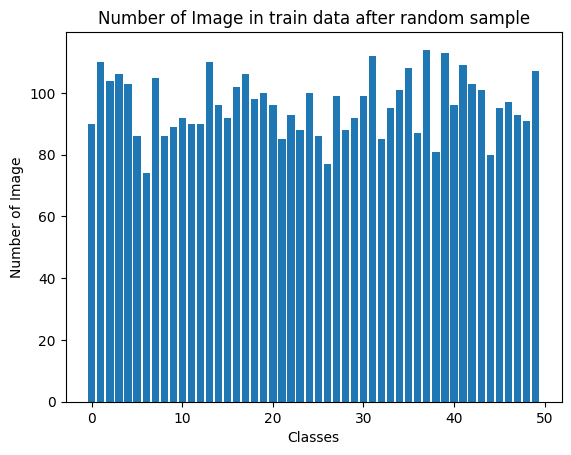

In [ ]:
li = {}

for data in train_dataloader:
  # print(data[1])
  for x in data[1].tolist():
    if x not in li:
      li[x] = 0
    li[x] += 1


plt.bar(li.keys(), li.values())

plt.xlabel('Classes')
plt.ylabel('Number of Image')
plt.title('Number of Image in train data after random sample')
plt.show()

In [ ]:
# Loss function
import torch.nn as nn
loss_fn = nn.CrossEntropyLoss()

## 3. Weighted Cross entropy loss

In [ ]:
train_data_ = TransformImbalanced(train_data, train_transform, train=True)
val_data_ = TransformImbalanced(val_data, test_val_transform, val=True)
test_data_ = TransformImbalanced(test_data, test_val_transform, test=True)

In [ ]:
# Create Dataloader
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data_, batch_size=32, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_data_, batch_size=32, shuffle=True, drop_last=True)

In [ ]:
class_cnt_
num_instances = [0]*50
for i in range(50):
  num_instances[i] = class_cnt_[i]
weights = [1-(x/sum(num_instances)) for x in num_instances]
class_weights = torch.FloatTensor(weights)
print(class_weights)

tensor([0.9867, 0.8950, 0.9896, 0.9169, 0.9802, 0.9606, 0.9773, 0.9844, 0.9944,
        0.9723, 0.9904, 0.9698, 0.9486, 0.9713, 0.9800, 0.9819, 0.9846, 0.9777,
        0.9669, 0.9900, 0.9877, 0.9773, 0.9908, 0.9833, 0.9850, 0.9623, 0.9633,
        0.9792, 0.9904, 0.9767, 0.9923, 0.9706, 0.9885, 0.9792, 0.9892, 0.9929,
        0.9869, 0.9963, 0.9925, 0.9890, 0.9871, 0.9892, 0.9963, 0.9869, 0.9879,
        0.9910, 0.9865, 0.9944, 0.9946, 0.9944])


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
weighted_loss_func = nn.CrossEntropyLoss(weight=class_weights.to(device))

cuda


## 4. Focal Loss

In [ ]:
train_data_ = TransformImbalanced(train_data, train_transform, train=True)
val_data_ = TransformImbalanced(val_data, test_val_transform, val=True)
test_data_ = TransformImbalanced(test_data, test_val_transform, test=True)

In [ ]:
# Create Dataloader
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data_, batch_size=32, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_data_, batch_size=32, shuffle=True, drop_last=True)

In [ ]:
def compute_per_class_alpha(class_cnt):
    total_samples = sum(class_cnt.values())

    raw_alphas = {cls: total_samples / count for cls, count in class_cnt.items()}

    total_alpha = sum(raw_alphas.values())
    normalized_alphas = {cls: alpha / total_alpha for cls, alpha in raw_alphas.items()}
    return normalized_alphas

# Example usage
alpha_values = compute_per_class_alpha(class_cnt_)
print("Per-class alpha values:", alpha_values)

Per-class alpha values: {20: 0.019568214014890017, 1: 0.0022907234660287912, 47: 0.04276017136587078, 31: 0.00818811792112419, 3: 0.0028935454307732105, 12: 0.004674188772787494, 9: 0.00868063629231963, 4: 0.012152890809247483, 28: 0.025098361453880672, 11: 0.007962238806058695, 6: 0.010591969053931293, 24: 0.01603506426220154, 32: 0.020991356852336565, 5: 0.006108595909410111, 18: 0.007261161175336547, 8: 0.04276017136587078, 15: 0.013270398010097828, 14: 0.012026298196651155, 41: 0.022202396670740594, 27: 0.011545246268785109, 13: 0.00836612048462689, 46: 0.017761917336592475, 35: 0.033956606672897384, 7: 0.01539366169171348, 29: 0.010308255597129563, 26: 0.006559799016355176, 33: 0.011545246268785109, 42: 0.06414025704880616, 25: 0.006378589098776304, 34: 0.022202396670740594, 21: 0.010591969053931293, 16: 0.015601684147006903, 39: 0.02178348352600964, 43: 0.01832578772823033, 30: 0.031203368294013805, 44: 0.019905597015146742, 23: 0.014431557835981388, 17: 0.010789949783911316, 10:

In [ ]:
print(sum(alpha_values.values()))

0.9999999999999998


In [ ]:
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=None):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha  # Dictionary alpha (per class)

    def forward(self, pred, true):
        pred_prob = torch.softmax(pred, dim=1)
        true_prob = pred_prob.gather(1, true.unsqueeze(1)).squeeze(1)

        if self.alpha is not None:
            alpha_factor = torch.tensor([self.alpha[c] for c in true.tolist()]).to(pred.device)
        else:
            alpha_factor = 1.0

        modulating_factor = (1 - true_prob) ** self.gamma
        focal_loss = -alpha_factor * modulating_factor * torch.log(true_prob + 1e-6)

        return focal_loss.mean()

focal_loss_func = FocalLoss(alpha=alpha_values)

# Training Loop

In [ ]:
# train / validate loop
def train_loop(dataloader, model, loss_func, optim, device):
  running_loss = 0
  total_correct = 0
  total_samples = len(dataloader.dataset)

  model.train()  # Training mode
  for i, input in enumerate(dataloader):
    data, label = input
    data = data.to(device)
    label = label.to(device)

    optim.zero_grad()
    output = model(data)
    loss = loss_func(output, label)
    loss.backward()
    optim.step()

    # Loss calculation
    running_loss += loss.item() * data.size(0)  # batch size applied

    # Accuracy calculation
    predicted = torch.argmax(output, dim=1)
    total_correct += (predicted == label).sum().item()

  avg_loss = running_loss / total_samples
  accuracy = total_correct / total_samples

  return avg_loss, accuracy


def validation_loop(dataloader, model, loss_func, device):
  running_loss = 0
  total_correct = 0
  total_samples = len(dataloader.dataset)

  model.eval()  # Evaluation mode
  with torch.no_grad():
    for i, input in enumerate(dataloader):
      data, label = input
      data = data.to(device)
      label = label.to(device)

      output = model(data)
      loss = loss_func(output, label)

      # Loss calculation
      running_loss += loss.item() * data.size(0)  # batch size

      # Accuracy calculation
      predicted = torch.argmax(output, dim=1)
      total_correct += (predicted == label).sum().item()

  avg_loss = running_loss / total_samples
  accuracy = total_correct / total_samples

  return avg_loss, accuracy

# Model Implementation

## VGG19 NET

In [ ]:
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm

In [ ]:
def conv_2_block(in_dim, out_dim):
  model = nn.Sequential(
    nn.Conv2d(in_dim, out_dim, kernel_size=3, padding=1),
    nn.BatchNorm2d(out_dim), # Place Batch norm in every step
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Conv2d(out_dim, out_dim, kernel_size=3, padding=1),
    nn.BatchNorm2d(out_dim),
    nn.ReLU(),
    #nn.Dropout(0.1),
    nn.MaxPool2d(2)
  )
  return model

def conv_3_block(in_dim, out_dim):
  model = nn.Sequential(
    nn.Conv2d(in_dim, out_dim, kernel_size=3, padding=1),
    nn.BatchNorm2d(out_dim),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Conv2d(out_dim, out_dim, kernel_size=3, padding=1),
    nn.BatchNorm2d(out_dim),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Conv2d(out_dim, out_dim, kernel_size=3, padding=1),
    nn.BatchNorm2d(out_dim),
    nn.MaxPool2d(2,2)
  )
  return model

In [ ]:
class VGG19(nn.Module):
  def __init__(self, base_dim, num_classes=50):
    super(VGG19, self).__init__()
    self.features = nn.Sequential(
        conv_2_block(3, base_dim),
        conv_2_block(base_dim, base_dim*2),
        conv_3_block(base_dim*2, base_dim*4),
        conv_3_block(base_dim*4, base_dim*8),
        conv_3_block(base_dim*8, base_dim*8), # 512
    )
    self.fc = nn.Sequential(
        nn.Linear(512 * 7 * 7, 4096),
        nn.ReLU(),
        nn.Dropout(),
        nn.Linear(4096, 1000),
        nn.ReLU(),
        #nn.Dropout(),
        nn.Linear(1000, num_classes)
    )

  def forward(self, x):
    x = self.features(x)
    x = x.view(x.size(0), -1)
    x = self.fc(x)
    return x

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VGG19(base_dim=64).to(device)

In [ ]:
import torch.optim as optim

learning_rate = 0.0002
num_epochs = 100

VGG19_model = VGG19(64, 50).to(device)

optimizer = Adam(VGG19_model.parameters(), lr = learning_rate, weight_decay = 0.001)
loss_func = nn.CrossEntropyLoss()
# scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer, lr_lambda=lambda epoch: 0.95 ** epoch)

cuda


In [ ]:
# Run VGG19

train_loss_li = []
train_acc_li = []
val_loss_li = []
val_acc_li = []
best_val_loss = float('inf')
best_val_acc = float('-inf')
best_model_loss = None
best_model_acc = None
cnt = 0

for epoch in tqdm(range(num_epochs)):
  train_loss, train_acc = train_loop(train_dataloader, VGG19_model, loss_func, optimizer, device)
  val_loss, val_acc = validation_loop(val_dataloader, VGG19_model, loss_func, device)
  train_loss_li.append(train_loss)
  train_acc_li.append(train_acc)
  val_loss_li.append(val_loss)
  val_acc_li.append(val_acc)

  if epoch % 1 == 0:
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

  # best model state 저장
  # early stop -> 15
  if val_loss < best_val_loss:
    best_val_loss = val_loss
    best_model_acc = VGG19_model.state_dict()
    print("Best model updated : validation loss of {}".format(best_val_loss))
    cnt = 0
  else:
    cnt+=1
    if cnt == 15:
      print("----Early stopping----")
      break

  1%|          | 1/100 [01:38<2:42:14, 98.33s/it]

Epoch 1/100, Train Loss: 4.1708, Train Acc: 0.0839, Val Loss: 3.2067, Val Acc: 0.1118
Best model updated : validation loss of 3.206734661027497


  2%|▏         | 2/100 [03:18<2:42:01, 99.20s/it]

Epoch 2/100, Train Loss: 3.7168, Train Acc: 0.1127, Val Loss: 3.0227, Val Acc: 0.1314
Best model updated : validation loss of 3.0226966708314187


  3%|▎         | 3/100 [04:58<2:41:28, 99.88s/it]

Epoch 3/100, Train Loss: 3.5359, Train Acc: 0.1239, Val Loss: 2.9569, Val Acc: 0.1255
Best model updated : validation loss of 2.9568776149375764


  4%|▍         | 4/100 [06:40<2:41:02, 100.65s/it]

Epoch 4/100, Train Loss: 3.4249, Train Acc: 0.1425, Val Loss: 2.8703, Val Acc: 0.1490
Best model updated : validation loss of 2.8702663945216758


  5%|▌         | 5/100 [08:22<2:40:11, 101.17s/it]

Epoch 5/100, Train Loss: 3.3866, Train Acc: 0.1491, Val Loss: 2.9725, Val Acc: 0.1235


  6%|▌         | 6/100 [10:05<2:39:13, 101.63s/it]

Epoch 6/100, Train Loss: 3.3129, Train Acc: 0.1693, Val Loss: 2.8637, Val Acc: 0.1392
Best model updated : validation loss of 2.863673999262791


  7%|▋         | 7/100 [11:47<2:37:56, 101.90s/it]

Epoch 7/100, Train Loss: 3.2719, Train Acc: 0.1662, Val Loss: 2.7982, Val Acc: 0.1804
Best model updated : validation loss of 2.798183007333793


  8%|▊         | 8/100 [13:30<2:36:33, 102.10s/it]

Epoch 8/100, Train Loss: 3.2422, Train Acc: 0.1804, Val Loss: 2.8174, Val Acc: 0.1647


  9%|▉         | 9/100 [15:12<2:35:06, 102.27s/it]

Epoch 9/100, Train Loss: 3.2419, Train Acc: 0.1795, Val Loss: 2.7463, Val Acc: 0.2020
Best model updated : validation loss of 2.746258066214767


 10%|█         | 10/100 [16:55<2:33:30, 102.34s/it]

Epoch 10/100, Train Loss: 3.2014, Train Acc: 0.1818, Val Loss: 2.6973, Val Acc: 0.1843
Best model updated : validation loss of 2.6972736732632505


 11%|█         | 11/100 [18:37<2:31:48, 102.34s/it]

Epoch 11/100, Train Loss: 3.1897, Train Acc: 0.1875, Val Loss: 2.7089, Val Acc: 0.1765


 12%|█▏        | 12/100 [20:21<2:30:34, 102.67s/it]

Epoch 12/100, Train Loss: 3.1632, Train Acc: 0.1935, Val Loss: 2.6687, Val Acc: 0.1980
Best model updated : validation loss of 2.6686572504978554


 13%|█▎        | 13/100 [22:04<2:28:59, 102.75s/it]

Epoch 13/100, Train Loss: 3.1353, Train Acc: 0.1989, Val Loss: 2.6770, Val Acc: 0.1922


 14%|█▍        | 14/100 [23:46<2:27:18, 102.77s/it]

Epoch 14/100, Train Loss: 3.1184, Train Acc: 0.2027, Val Loss: 2.8818, Val Acc: 0.1647


 15%|█▌        | 15/100 [25:29<2:25:36, 102.79s/it]

Epoch 15/100, Train Loss: 3.1068, Train Acc: 0.2025, Val Loss: 2.6163, Val Acc: 0.2118
Best model updated : validation loss of 2.616251837038526


 16%|█▌        | 16/100 [27:12<2:23:44, 102.67s/it]

Epoch 16/100, Train Loss: 3.0887, Train Acc: 0.2116, Val Loss: 2.6349, Val Acc: 0.2039


 17%|█▋        | 17/100 [28:54<2:22:00, 102.65s/it]

Epoch 17/100, Train Loss: 3.0766, Train Acc: 0.2108, Val Loss: 2.6387, Val Acc: 0.2059


 18%|█▊        | 18/100 [30:37<2:20:10, 102.57s/it]

Epoch 18/100, Train Loss: 3.0719, Train Acc: 0.2004, Val Loss: 2.5945, Val Acc: 0.2216
Best model updated : validation loss of 2.5945063572303924


 19%|█▉        | 19/100 [32:19<2:18:28, 102.57s/it]

Epoch 19/100, Train Loss: 3.0328, Train Acc: 0.2218, Val Loss: 2.6730, Val Acc: 0.1882


 20%|██        | 20/100 [34:02<2:16:48, 102.61s/it]

Epoch 20/100, Train Loss: 3.0628, Train Acc: 0.2085, Val Loss: 2.5926, Val Acc: 0.2039
Best model updated : validation loss of 2.592644276338465


 21%|██        | 21/100 [35:44<2:14:52, 102.44s/it]

Epoch 21/100, Train Loss: 3.0243, Train Acc: 0.2225, Val Loss: 2.5354, Val Acc: 0.2176
Best model updated : validation loss of 2.5353656544404872


 22%|██▏       | 22/100 [37:26<2:12:56, 102.26s/it]

Epoch 22/100, Train Loss: 2.9954, Train Acc: 0.2310, Val Loss: 2.5131, Val Acc: 0.2510
Best model updated : validation loss of 2.513142963484222


 23%|██▎       | 23/100 [39:08<2:11:01, 102.10s/it]

Epoch 23/100, Train Loss: 3.0081, Train Acc: 0.2189, Val Loss: 2.5891, Val Acc: 0.2275


 24%|██▍       | 24/100 [40:50<2:09:24, 102.17s/it]

Epoch 24/100, Train Loss: 2.9800, Train Acc: 0.2327, Val Loss: 2.6364, Val Acc: 0.2078


 25%|██▌       | 25/100 [42:32<2:07:45, 102.21s/it]

Epoch 25/100, Train Loss: 2.9753, Train Acc: 0.2258, Val Loss: 2.5051, Val Acc: 0.2314
Best model updated : validation loss of 2.5050754621917126


 26%|██▌       | 26/100 [44:14<2:06:06, 102.25s/it]

Epoch 26/100, Train Loss: 2.9704, Train Acc: 0.2264, Val Loss: 2.4619, Val Acc: 0.2529
Best model updated : validation loss of 2.4618730133655022


 27%|██▋       | 27/100 [45:57<2:04:24, 102.26s/it]

Epoch 27/100, Train Loss: 2.9411, Train Acc: 0.2347, Val Loss: 2.5955, Val Acc: 0.2137


 28%|██▊       | 28/100 [47:39<2:02:44, 102.28s/it]

Epoch 28/100, Train Loss: 2.9321, Train Acc: 0.2447, Val Loss: 2.4587, Val Acc: 0.2314
Best model updated : validation loss of 2.4586923337450215


 29%|██▉       | 29/100 [49:21<2:01:04, 102.32s/it]

Epoch 29/100, Train Loss: 2.9313, Train Acc: 0.2445, Val Loss: 2.4935, Val Acc: 0.2431


 30%|███       | 30/100 [51:04<1:59:25, 102.36s/it]

Epoch 30/100, Train Loss: 2.9002, Train Acc: 0.2395, Val Loss: 2.5232, Val Acc: 0.2196


 31%|███       | 31/100 [52:47<1:57:48, 102.44s/it]

Epoch 31/100, Train Loss: 2.8822, Train Acc: 0.2452, Val Loss: 2.6108, Val Acc: 0.2137


 32%|███▏      | 32/100 [54:29<1:56:13, 102.56s/it]

Epoch 32/100, Train Loss: 2.8439, Train Acc: 0.2606, Val Loss: 2.5880, Val Acc: 0.2314


 33%|███▎      | 33/100 [56:12<1:54:32, 102.58s/it]

Epoch 33/100, Train Loss: 2.8536, Train Acc: 0.2558, Val Loss: 2.4150, Val Acc: 0.2412
Best model updated : validation loss of 2.415015516094133


 34%|███▍      | 34/100 [57:54<1:52:47, 102.53s/it]

Epoch 34/100, Train Loss: 2.8183, Train Acc: 0.2593, Val Loss: 2.3579, Val Acc: 0.2725
Best model updated : validation loss of 2.357900971057368


 35%|███▌      | 35/100 [59:37<1:51:03, 102.51s/it]

Epoch 35/100, Train Loss: 2.8063, Train Acc: 0.2577, Val Loss: 2.4128, Val Acc: 0.2353


 36%|███▌      | 36/100 [1:01:19<1:49:20, 102.51s/it]

Epoch 36/100, Train Loss: 2.7965, Train Acc: 0.2660, Val Loss: 2.4402, Val Acc: 0.2471


 37%|███▋      | 37/100 [1:03:02<1:47:31, 102.41s/it]

Epoch 37/100, Train Loss: 2.7969, Train Acc: 0.2597, Val Loss: 2.4863, Val Acc: 0.2255


 38%|███▊      | 38/100 [1:04:44<1:45:50, 102.42s/it]

Epoch 38/100, Train Loss: 2.7753, Train Acc: 0.2610, Val Loss: 2.3543, Val Acc: 0.2471
Best model updated : validation loss of 2.354347588034237


 39%|███▉      | 39/100 [1:06:27<1:44:08, 102.43s/it]

Epoch 39/100, Train Loss: 2.7856, Train Acc: 0.2566, Val Loss: 2.4897, Val Acc: 0.2353


 40%|████      | 40/100 [1:08:09<1:42:22, 102.38s/it]

Epoch 40/100, Train Loss: 2.7498, Train Acc: 0.2714, Val Loss: 2.3331, Val Acc: 0.2510
Best model updated : validation loss of 2.333095774931066


 41%|████      | 41/100 [1:09:51<1:40:40, 102.39s/it]

Epoch 41/100, Train Loss: 2.7402, Train Acc: 0.2683, Val Loss: 2.5699, Val Acc: 0.2412


 42%|████▏     | 42/100 [1:11:34<1:39:01, 102.45s/it]

Epoch 42/100, Train Loss: 2.7358, Train Acc: 0.2687, Val Loss: 2.3715, Val Acc: 0.2451


 43%|████▎     | 43/100 [1:13:16<1:37:19, 102.44s/it]

Epoch 43/100, Train Loss: 2.7133, Train Acc: 0.2747, Val Loss: 2.5146, Val Acc: 0.2510


 44%|████▍     | 44/100 [1:14:59<1:35:40, 102.50s/it]

Epoch 44/100, Train Loss: 2.6747, Train Acc: 0.2806, Val Loss: 2.3333, Val Acc: 0.2765


 45%|████▌     | 45/100 [1:16:42<1:34:02, 102.58s/it]

Epoch 45/100, Train Loss: 2.6885, Train Acc: 0.2860, Val Loss: 2.2360, Val Acc: 0.2765
Best model updated : validation loss of 2.235954075233609


 46%|████▌     | 46/100 [1:18:24<1:32:20, 102.60s/it]

Epoch 46/100, Train Loss: 2.6618, Train Acc: 0.2835, Val Loss: 2.3473, Val Acc: 0.2431


 47%|████▋     | 47/100 [1:20:07<1:30:39, 102.63s/it]

Epoch 47/100, Train Loss: 2.6566, Train Acc: 0.2885, Val Loss: 2.2117, Val Acc: 0.2686
Best model updated : validation loss of 2.2116648954503675


 48%|████▊     | 48/100 [1:21:49<1:28:55, 102.60s/it]

Epoch 48/100, Train Loss: 2.6305, Train Acc: 0.2912, Val Loss: 2.3348, Val Acc: 0.2431


 49%|████▉     | 49/100 [1:23:32<1:27:12, 102.59s/it]

Epoch 49/100, Train Loss: 2.6286, Train Acc: 0.2956, Val Loss: 2.4114, Val Acc: 0.2431


 50%|█████     | 50/100 [1:25:15<1:25:28, 102.57s/it]

Epoch 50/100, Train Loss: 2.6100, Train Acc: 0.2972, Val Loss: 2.2008, Val Acc: 0.2627
Best model updated : validation loss of 2.200839682186351


 51%|█████     | 51/100 [1:26:57<1:23:45, 102.57s/it]

Epoch 51/100, Train Loss: 2.6069, Train Acc: 0.2947, Val Loss: 2.2956, Val Acc: 0.2765


 52%|█████▏    | 52/100 [1:28:39<1:21:58, 102.48s/it]

Epoch 52/100, Train Loss: 2.6019, Train Acc: 0.2989, Val Loss: 2.1847, Val Acc: 0.2843
Best model updated : validation loss of 2.1846940582873775


 53%|█████▎    | 53/100 [1:30:22<1:20:16, 102.49s/it]

Epoch 53/100, Train Loss: 2.5887, Train Acc: 0.2981, Val Loss: 2.2855, Val Acc: 0.2804


 54%|█████▍    | 54/100 [1:32:05<1:18:37, 102.54s/it]

Epoch 54/100, Train Loss: 2.5889, Train Acc: 0.3033, Val Loss: 2.3471, Val Acc: 0.2569


 55%|█████▌    | 55/100 [1:33:47<1:16:56, 102.59s/it]

Epoch 55/100, Train Loss: 2.5749, Train Acc: 0.2947, Val Loss: 2.5128, Val Acc: 0.2392


 56%|█████▌    | 56/100 [1:35:30<1:15:14, 102.61s/it]

Epoch 56/100, Train Loss: 2.5572, Train Acc: 0.3024, Val Loss: 2.1690, Val Acc: 0.2725
Best model updated : validation loss of 2.1689889346852023


 57%|█████▋    | 57/100 [1:37:13<1:13:33, 102.63s/it]

Epoch 57/100, Train Loss: 2.5392, Train Acc: 0.3112, Val Loss: 2.2244, Val Acc: 0.2961


 58%|█████▊    | 58/100 [1:38:56<1:11:53, 102.71s/it]

Epoch 58/100, Train Loss: 2.5167, Train Acc: 0.3176, Val Loss: 2.2386, Val Acc: 0.2706


 59%|█████▉    | 59/100 [1:40:38<1:10:06, 102.61s/it]

Epoch 59/100, Train Loss: 2.5186, Train Acc: 0.3214, Val Loss: 2.2139, Val Acc: 0.2706


 60%|██████    | 60/100 [1:42:20<1:08:19, 102.49s/it]

Epoch 60/100, Train Loss: 2.5214, Train Acc: 0.3141, Val Loss: 2.3598, Val Acc: 0.2608


 61%|██████    | 61/100 [1:44:03<1:06:38, 102.52s/it]

Epoch 61/100, Train Loss: 2.5171, Train Acc: 0.3151, Val Loss: 2.3203, Val Acc: 0.2627


 62%|██████▏   | 62/100 [1:45:45<1:04:57, 102.57s/it]

Epoch 62/100, Train Loss: 2.4895, Train Acc: 0.3266, Val Loss: 2.3578, Val Acc: 0.2843


 63%|██████▎   | 63/100 [1:47:28<1:03:13, 102.52s/it]

Epoch 63/100, Train Loss: 2.4990, Train Acc: 0.3193, Val Loss: 2.1837, Val Acc: 0.2471


 64%|██████▍   | 64/100 [1:49:11<1:01:34, 102.62s/it]

Epoch 64/100, Train Loss: 2.4636, Train Acc: 0.3262, Val Loss: 2.1233, Val Acc: 0.3078
Best model updated : validation loss of 2.1233373006184895


 65%|██████▌   | 65/100 [1:50:54<59:56, 102.76s/it]  

Epoch 65/100, Train Loss: 2.4763, Train Acc: 0.3258, Val Loss: 2.4449, Val Acc: 0.2588


 66%|██████▌   | 66/100 [1:52:36<58:11, 102.70s/it]

Epoch 66/100, Train Loss: 2.4670, Train Acc: 0.3224, Val Loss: 2.1629, Val Acc: 0.2686


 67%|██████▋   | 67/100 [1:54:19<56:30, 102.75s/it]

Epoch 67/100, Train Loss: 2.4203, Train Acc: 0.3387, Val Loss: 2.1938, Val Acc: 0.2667


 68%|██████▊   | 68/100 [1:56:02<54:47, 102.74s/it]

Epoch 68/100, Train Loss: 2.4435, Train Acc: 0.3276, Val Loss: 2.1235, Val Acc: 0.2961


 69%|██████▉   | 69/100 [1:57:45<53:04, 102.73s/it]

Epoch 69/100, Train Loss: 2.4501, Train Acc: 0.3266, Val Loss: 2.1534, Val Acc: 0.2765


 70%|███████   | 70/100 [1:59:27<51:21, 102.72s/it]

Epoch 70/100, Train Loss: 2.4235, Train Acc: 0.3289, Val Loss: 2.3804, Val Acc: 0.2588


 71%|███████   | 71/100 [2:01:10<49:37, 102.69s/it]

Epoch 71/100, Train Loss: 2.4114, Train Acc: 0.3353, Val Loss: 2.1937, Val Acc: 0.2863


 72%|███████▏  | 72/100 [2:02:52<47:53, 102.62s/it]

Epoch 72/100, Train Loss: 2.4096, Train Acc: 0.3328, Val Loss: 2.0984, Val Acc: 0.3137
Best model updated : validation loss of 2.098418680826823


 73%|███████▎  | 73/100 [2:04:35<46:11, 102.65s/it]

Epoch 73/100, Train Loss: 2.4093, Train Acc: 0.3366, Val Loss: 2.3012, Val Acc: 0.2431


 74%|███████▍  | 74/100 [2:06:18<44:27, 102.60s/it]

Epoch 74/100, Train Loss: 2.3861, Train Acc: 0.3374, Val Loss: 2.1913, Val Acc: 0.2824


 75%|███████▌  | 75/100 [2:08:00<42:44, 102.58s/it]

Epoch 75/100, Train Loss: 2.3822, Train Acc: 0.3474, Val Loss: 2.0817, Val Acc: 0.3020
Best model updated : validation loss of 2.0816798789828432


 76%|███████▌  | 76/100 [2:09:43<41:01, 102.54s/it]

Epoch 76/100, Train Loss: 2.3895, Train Acc: 0.3349, Val Loss: 2.2321, Val Acc: 0.2784


 77%|███████▋  | 77/100 [2:11:25<39:17, 102.48s/it]

Epoch 77/100, Train Loss: 2.3568, Train Acc: 0.3447, Val Loss: 2.1736, Val Acc: 0.2980


 78%|███████▊  | 78/100 [2:13:08<37:39, 102.70s/it]

Epoch 78/100, Train Loss: 2.3463, Train Acc: 0.3422, Val Loss: 2.0842, Val Acc: 0.3353


 79%|███████▉  | 79/100 [2:14:51<35:58, 102.80s/it]

Epoch 79/100, Train Loss: 2.3692, Train Acc: 0.3433, Val Loss: 2.1107, Val Acc: 0.3059


 80%|████████  | 80/100 [2:16:34<34:17, 102.89s/it]

Epoch 80/100, Train Loss: 2.3233, Train Acc: 0.3551, Val Loss: 2.1171, Val Acc: 0.3000


 81%|████████  | 81/100 [2:18:17<32:36, 102.97s/it]

Epoch 81/100, Train Loss: 2.3303, Train Acc: 0.3566, Val Loss: 2.1420, Val Acc: 0.3059


 82%|████████▏ | 82/100 [2:20:00<30:54, 103.01s/it]

Epoch 82/100, Train Loss: 2.3403, Train Acc: 0.3531, Val Loss: 1.9516, Val Acc: 0.3490
Best model updated : validation loss of 1.9516313141467525


 83%|████████▎ | 83/100 [2:21:44<29:12, 103.09s/it]

Epoch 83/100, Train Loss: 2.3111, Train Acc: 0.3483, Val Loss: 2.0965, Val Acc: 0.2784


 84%|████████▍ | 84/100 [2:23:27<27:29, 103.11s/it]

Epoch 84/100, Train Loss: 2.3182, Train Acc: 0.3591, Val Loss: 2.1638, Val Acc: 0.2902


 85%|████████▌ | 85/100 [2:25:10<25:45, 103.06s/it]

Epoch 85/100, Train Loss: 2.2969, Train Acc: 0.3685, Val Loss: 1.9958, Val Acc: 0.3353


 86%|████████▌ | 86/100 [2:26:53<24:03, 103.07s/it]

Epoch 86/100, Train Loss: 2.3059, Train Acc: 0.3553, Val Loss: 2.1497, Val Acc: 0.2902


 87%|████████▋ | 87/100 [2:28:36<22:20, 103.11s/it]

Epoch 87/100, Train Loss: 2.2772, Train Acc: 0.3643, Val Loss: 2.1009, Val Acc: 0.3000


 88%|████████▊ | 88/100 [2:30:19<20:36, 103.08s/it]

Epoch 88/100, Train Loss: 2.2650, Train Acc: 0.3680, Val Loss: 2.2045, Val Acc: 0.2961


 89%|████████▉ | 89/100 [2:32:02<18:52, 102.99s/it]

Epoch 89/100, Train Loss: 2.2608, Train Acc: 0.3666, Val Loss: 2.0919, Val Acc: 0.3157


 90%|█████████ | 90/100 [2:33:45<17:08, 102.90s/it]

Epoch 90/100, Train Loss: 2.2669, Train Acc: 0.3643, Val Loss: 2.1978, Val Acc: 0.2706


 91%|█████████ | 91/100 [2:35:27<15:25, 102.81s/it]

Epoch 91/100, Train Loss: 2.2590, Train Acc: 0.3624, Val Loss: 2.1287, Val Acc: 0.3098


 92%|█████████▏| 92/100 [2:37:10<13:42, 102.76s/it]

Epoch 92/100, Train Loss: 2.2703, Train Acc: 0.3664, Val Loss: 2.2750, Val Acc: 0.2922


 93%|█████████▎| 93/100 [2:38:52<11:59, 102.72s/it]

Epoch 93/100, Train Loss: 2.2255, Train Acc: 0.3726, Val Loss: 2.4321, Val Acc: 0.2510


 94%|█████████▍| 94/100 [2:40:35<10:15, 102.63s/it]

Epoch 94/100, Train Loss: 2.2161, Train Acc: 0.3789, Val Loss: 1.9907, Val Acc: 0.3353


 95%|█████████▌| 95/100 [2:42:18<08:33, 102.63s/it]

Epoch 95/100, Train Loss: 2.2111, Train Acc: 0.3853, Val Loss: 2.1223, Val Acc: 0.2843


 96%|█████████▌| 96/100 [2:44:00<06:50, 102.53s/it]

Epoch 96/100, Train Loss: 2.1918, Train Acc: 0.3816, Val Loss: 2.0691, Val Acc: 0.3196


 96%|█████████▌| 96/100 [2:45:42<06:54, 103.57s/it]

Epoch 97/100, Train Loss: 2.2087, Train Acc: 0.3874, Val Loss: 2.3024, Val Acc: 0.3059
----Early stopping----


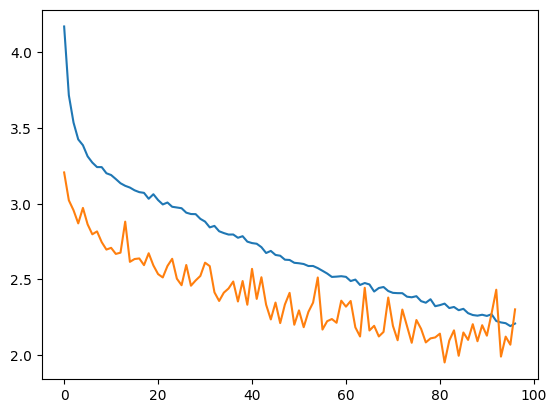

In [ ]:
# blue: train loss
# orange: validation loss
plt.plot(train_loss_li)
plt.plot(val_loss_li)

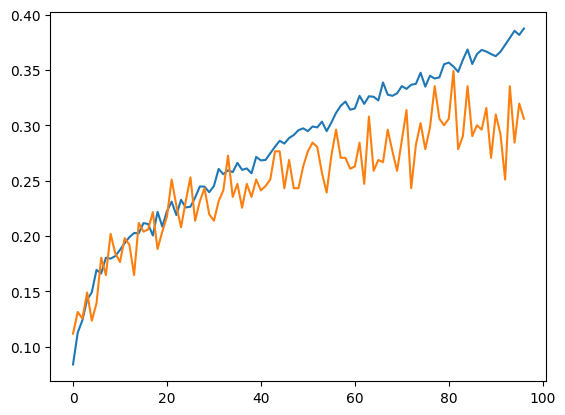

In [ ]:
# blue: train accuracy
# orange: validation accuracy
plt.plot(train_acc_li)
plt.plot(val_acc_li)

## MobileNet

In [ ]:
import torch
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm

In [ ]:
class Depthwise_block_(nn.Module):
  def __init__(self, in_dim, out_dim, stride=1):
    super(Depthwise_block_, self).__init__()

    self.depthwise = nn.Sequential(
        nn.Conv2d(in_dim, in_dim, kernel_size=3, padding=1, groups=in_dim, stride=stride, bias=False),
        nn.BatchNorm2d(in_dim),
        nn.ReLU6(), # GELU?
        #nn.Dropout(0.1),
    )

    self.pointwise = nn.Sequential(
        nn.Conv2d(in_dim, out_dim, kernel_size=1, stride=stride, bias=False),
        nn.BatchNorm2d(out_dim),
        nn.ReLU6(),
        #nn.Dropout(0.1),
    )

  def forward(self, x):
    x = self.depthwise(x)
    x = self.pointwise(x)
    return x

In [ ]:
class BasicConv_(nn.Module):
  def __init__(self, in_dim, out_dim, kernel_size, **kwargs):
    super(BasicConv_, self).__init__()

    self.conv = nn.Sequential(
        nn.Conv2d(in_dim, out_dim, kernel_size=kernel_size,**kwargs),
        nn.BatchNorm2d(out_dim),
        nn.ReLU(),
        #nn.Dropout(0.2),
    )
  def forward(self, x):
    x = self.conv(x)
    return x

In [ ]:
class MobileNet2(nn.Module):
  def __init__(self, alpha, num_classes=50): # alpha controls complexity
    super(MobileNet2, self).__init__()

    self.conv1 = BasicConv_(3, int(32*alpha), 3, stride=2, padding=1)
    self.conv2 = Depthwise_block_(int(32*alpha), int(64*alpha), stride=1)

    self.conv3 = nn.Sequential(
        Depthwise_block_(int(64*alpha), int(128*alpha), stride=2),
        Depthwise_block_(int(128*alpha), int(128*alpha), stride=1),
    )

    self.conv4 = nn.Sequential(
        Depthwise_block_(int(128*alpha), int(256*alpha), stride=2),
        Depthwise_block_(int(256*alpha), int(256*alpha), stride=1),
    )

    self.conv5 = nn.Sequential(
        Depthwise_block_(int(256*alpha), int(512*alpha), stride=2),
        Depthwise_block_(int(512*alpha), int(512*alpha), stride=1),
        Depthwise_block_(int(512*alpha), int(512*alpha), stride=1),
        Depthwise_block_(int(512*alpha), int(512*alpha), stride=1),
        Depthwise_block_(int(512*alpha), int(512*alpha), stride=1),
        Depthwise_block_(int(512*alpha), int(512*alpha), stride=1),
        Depthwise_block_(int(512*alpha), int(512*alpha), stride=1),
    )

    self.conv6 = nn.Sequential(
        Depthwise_block_(int(512*alpha), int(1024*alpha), stride=2),
    )

    self.conv7 = nn.Sequential(
        Depthwise_block_(int(1024*alpha), int(1024*alpha), stride=1),
    )

    self.avgpool = nn.AdaptiveAvgPool2d(1)
    self.fc_layer = nn.Linear(int(1024*alpha), num_classes)


  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.conv5(x)
    x = self.conv6(x)
    x = self.conv7(x)
    x = self.avgpool(x)
    x = x.view(x.size(0), -1)
    x = self.fc_layer(x)
    return x


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MobileNet2(alpha=1).to(device)

In [ ]:
import torch.optim as optim

learning_rate = 0.006
num_epochs = 100

mobileNet = MobileNet2(0.85, 50).to(device) # adjusted alpha value to avoid overfitting

optimizer = Adam(mobileNet.parameters(), lr = learning_rate, weight_decay = 0.0001)

cuda


In [ ]:
"""
모델 돌리는 코드!!!!!!
돌리기 전에 주의
"""

# augmentation에 distortion 지우자

# weights and bias library 사용!

train_loss_li = []
train_acc_li = []
val_loss_li = []
val_acc_li = []
best_val_loss = float('inf')
best_val_acc = float('-inf')
best_model_loss = None
best_model_acc = None
cnt = 0

for epoch in tqdm(range(num_epochs)):
  train_loss, train_acc = train_loop(train_dataloader, mobileNet, loss_func, optimizer, scheduler, device)
  val_loss, val_acc = validation_loop(val_dataloader, mobileNet, loss_func, device)
  train_loss_li.append(train_loss)
  train_acc_li.append(train_acc)
  val_loss_li.append(val_loss)
  val_acc_li.append(val_acc)

  if epoch % 1 == 0:
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

  # best model state 저장
  if val_acc > best_val_acc:
    best_val_acc = val_acc
    best_model_acc = mobileNet.state_dict()
    print("Best model updated : validation accuracy of {}".format(best_val_acc))
    cnt = 0
  else:
    cnt+=1
    if cnt == 15:
      print("----Early stopping----")
      break


  1%|          | 1/100 [00:22<36:48, 22.31s/it]

Epoch 1/100, Train Loss: 3.3572, Train Acc: 0.1410, Val Loss: 2.8780, Val Acc: 0.1275
Best model updated : validation accuracy of 0.12745098039215685


  2%|▏         | 2/100 [00:44<36:40, 22.45s/it]

Epoch 2/100, Train Loss: 3.2708, Train Acc: 0.1693, Val Loss: 2.8839, Val Acc: 0.1471
Best model updated : validation accuracy of 0.14705882352941177


  3%|▎         | 3/100 [01:07<36:22, 22.50s/it]

Epoch 3/100, Train Loss: 3.2374, Train Acc: 0.1741, Val Loss: 2.9307, Val Acc: 0.1294


  4%|▍         | 4/100 [01:29<35:51, 22.41s/it]

Epoch 4/100, Train Loss: 3.2025, Train Acc: 0.1766, Val Loss: 2.8028, Val Acc: 0.1510
Best model updated : validation accuracy of 0.15098039215686274


  5%|▌         | 5/100 [01:52<35:33, 22.46s/it]

Epoch 5/100, Train Loss: 3.1802, Train Acc: 0.1860, Val Loss: 3.1355, Val Acc: 0.1529
Best model updated : validation accuracy of 0.15294117647058825


  6%|▌         | 6/100 [02:14<35:15, 22.51s/it]

Epoch 6/100, Train Loss: 3.1666, Train Acc: 0.1860, Val Loss: 2.8423, Val Acc: 0.1686
Best model updated : validation accuracy of 0.16862745098039217


  7%|▋         | 7/100 [02:37<35:09, 22.69s/it]

Epoch 7/100, Train Loss: 3.1498, Train Acc: 0.1970, Val Loss: 2.7032, Val Acc: 0.1765
Best model updated : validation accuracy of 0.17647058823529413


  8%|▊         | 8/100 [03:00<34:42, 22.64s/it]

Epoch 8/100, Train Loss: 3.1099, Train Acc: 0.2047, Val Loss: 2.6931, Val Acc: 0.1843
Best model updated : validation accuracy of 0.1843137254901961


  9%|▉         | 9/100 [03:22<34:17, 22.61s/it]

Epoch 9/100, Train Loss: 3.1576, Train Acc: 0.1881, Val Loss: 2.9345, Val Acc: 0.1706


 10%|█         | 10/100 [03:45<33:55, 22.61s/it]

Epoch 10/100, Train Loss: 3.1350, Train Acc: 0.1958, Val Loss: 2.8615, Val Acc: 0.1373


 11%|█         | 11/100 [04:07<33:24, 22.52s/it]

Epoch 11/100, Train Loss: 3.0705, Train Acc: 0.2045, Val Loss: 2.7559, Val Acc: 0.1824


 12%|█▏        | 12/100 [04:30<32:55, 22.44s/it]

Epoch 12/100, Train Loss: 3.0392, Train Acc: 0.2108, Val Loss: 2.7557, Val Acc: 0.2020
Best model updated : validation accuracy of 0.2019607843137255


 13%|█▎        | 13/100 [04:52<32:26, 22.38s/it]

Epoch 13/100, Train Loss: 3.0209, Train Acc: 0.2145, Val Loss: 2.7493, Val Acc: 0.1863


 14%|█▍        | 14/100 [05:14<32:00, 22.33s/it]

Epoch 14/100, Train Loss: 2.9992, Train Acc: 0.2085, Val Loss: 2.6659, Val Acc: 0.1863


 15%|█▌        | 15/100 [05:37<31:50, 22.47s/it]

Epoch 15/100, Train Loss: 2.9812, Train Acc: 0.2147, Val Loss: 2.6391, Val Acc: 0.1608


 16%|█▌        | 16/100 [05:59<31:23, 22.43s/it]

Epoch 16/100, Train Loss: 2.9607, Train Acc: 0.2252, Val Loss: 2.5932, Val Acc: 0.2059
Best model updated : validation accuracy of 0.20588235294117646


 17%|█▋        | 17/100 [06:22<31:01, 22.43s/it]

Epoch 17/100, Train Loss: 2.9256, Train Acc: 0.2329, Val Loss: 2.6165, Val Acc: 0.2235
Best model updated : validation accuracy of 0.2235294117647059


 18%|█▊        | 18/100 [06:44<30:33, 22.35s/it]

Epoch 18/100, Train Loss: 2.9111, Train Acc: 0.2345, Val Loss: 2.8107, Val Acc: 0.1569


 19%|█▉        | 19/100 [07:06<30:12, 22.38s/it]

Epoch 19/100, Train Loss: 2.9035, Train Acc: 0.2375, Val Loss: 2.6257, Val Acc: 0.1627


 20%|██        | 20/100 [07:29<29:47, 22.35s/it]

Epoch 20/100, Train Loss: 2.8704, Train Acc: 0.2464, Val Loss: 2.5834, Val Acc: 0.2059


 21%|██        | 21/100 [07:51<29:28, 22.39s/it]

Epoch 21/100, Train Loss: 2.8644, Train Acc: 0.2454, Val Loss: 2.4918, Val Acc: 0.2412
Best model updated : validation accuracy of 0.2411764705882353


 22%|██▏       | 22/100 [08:13<29:05, 22.38s/it]

Epoch 22/100, Train Loss: 2.8360, Train Acc: 0.2456, Val Loss: 2.6393, Val Acc: 0.1941


 23%|██▎       | 23/100 [08:36<28:38, 22.31s/it]

Epoch 23/100, Train Loss: 2.8374, Train Acc: 0.2454, Val Loss: 2.5116, Val Acc: 0.2275


 24%|██▍       | 24/100 [08:58<28:17, 22.33s/it]

Epoch 24/100, Train Loss: 2.8169, Train Acc: 0.2527, Val Loss: 2.5234, Val Acc: 0.2118


 25%|██▌       | 25/100 [09:21<27:59, 22.40s/it]

Epoch 25/100, Train Loss: 2.8085, Train Acc: 0.2435, Val Loss: 2.5117, Val Acc: 0.2314


 26%|██▌       | 26/100 [09:43<27:39, 22.42s/it]

Epoch 26/100, Train Loss: 2.8061, Train Acc: 0.2468, Val Loss: 2.5551, Val Acc: 0.2137


 27%|██▋       | 27/100 [10:06<27:20, 22.48s/it]

Epoch 27/100, Train Loss: 2.7907, Train Acc: 0.2556, Val Loss: 2.4399, Val Acc: 0.2451
Best model updated : validation accuracy of 0.24509803921568626


 28%|██▊       | 28/100 [10:28<27:02, 22.54s/it]

Epoch 28/100, Train Loss: 2.7428, Train Acc: 0.2647, Val Loss: 2.5914, Val Acc: 0.2098


 29%|██▉       | 29/100 [10:51<26:43, 22.59s/it]

Epoch 29/100, Train Loss: 2.7369, Train Acc: 0.2649, Val Loss: 2.8396, Val Acc: 0.2039


 30%|███       | 30/100 [11:14<26:25, 22.65s/it]

Epoch 30/100, Train Loss: 2.7124, Train Acc: 0.2695, Val Loss: 2.4808, Val Acc: 0.2314


 31%|███       | 31/100 [11:36<26:03, 22.65s/it]

Epoch 31/100, Train Loss: 2.6831, Train Acc: 0.2804, Val Loss: 2.6480, Val Acc: 0.1804


 32%|███▏      | 32/100 [11:59<25:42, 22.68s/it]

Epoch 32/100, Train Loss: 2.6568, Train Acc: 0.2843, Val Loss: 2.3900, Val Acc: 0.2510
Best model updated : validation accuracy of 0.25098039215686274


 33%|███▎      | 33/100 [12:22<25:22, 22.72s/it]

Epoch 33/100, Train Loss: 2.6616, Train Acc: 0.2881, Val Loss: 2.4163, Val Acc: 0.2333


 34%|███▍      | 34/100 [12:45<25:04, 22.79s/it]

Epoch 34/100, Train Loss: 2.6063, Train Acc: 0.2887, Val Loss: 2.4340, Val Acc: 0.2235


 35%|███▌      | 35/100 [13:07<24:36, 22.71s/it]

Epoch 35/100, Train Loss: 2.6303, Train Acc: 0.2924, Val Loss: 2.7049, Val Acc: 0.2059


 36%|███▌      | 36/100 [13:30<24:10, 22.67s/it]

Epoch 36/100, Train Loss: 2.6084, Train Acc: 0.2908, Val Loss: 2.9243, Val Acc: 0.1706


 37%|███▋      | 37/100 [13:53<23:47, 22.66s/it]

Epoch 37/100, Train Loss: 2.6043, Train Acc: 0.2968, Val Loss: 2.6941, Val Acc: 0.1922


 38%|███▊      | 38/100 [14:15<23:23, 22.63s/it]

Epoch 38/100, Train Loss: 2.5667, Train Acc: 0.2993, Val Loss: 2.4368, Val Acc: 0.2314


 39%|███▉      | 39/100 [14:38<23:04, 22.70s/it]

Epoch 39/100, Train Loss: 2.5794, Train Acc: 0.2989, Val Loss: 2.2700, Val Acc: 0.2549
Best model updated : validation accuracy of 0.2549019607843137


 40%|████      | 40/100 [15:01<22:50, 22.83s/it]

Epoch 40/100, Train Loss: 2.5580, Train Acc: 0.2999, Val Loss: 2.5755, Val Acc: 0.2020


 41%|████      | 41/100 [15:24<22:25, 22.80s/it]

Epoch 41/100, Train Loss: 2.5427, Train Acc: 0.3116, Val Loss: 2.4088, Val Acc: 0.2549


 42%|████▏     | 42/100 [15:46<21:52, 22.63s/it]

Epoch 42/100, Train Loss: 2.5330, Train Acc: 0.3114, Val Loss: 2.2260, Val Acc: 0.2882
Best model updated : validation accuracy of 0.28823529411764703


 43%|████▎     | 43/100 [16:08<21:22, 22.50s/it]

Epoch 43/100, Train Loss: 2.5013, Train Acc: 0.3104, Val Loss: 2.4423, Val Acc: 0.2392


 44%|████▍     | 44/100 [16:31<21:02, 22.55s/it]

Epoch 44/100, Train Loss: 2.5256, Train Acc: 0.3120, Val Loss: 2.8134, Val Acc: 0.1980


 45%|████▌     | 45/100 [16:53<20:34, 22.45s/it]

Epoch 45/100, Train Loss: 2.4994, Train Acc: 0.3170, Val Loss: 2.7506, Val Acc: 0.1745


 46%|████▌     | 46/100 [17:16<20:14, 22.49s/it]

Epoch 46/100, Train Loss: 2.4712, Train Acc: 0.3160, Val Loss: 2.4810, Val Acc: 0.2314


 47%|████▋     | 47/100 [17:38<19:53, 22.52s/it]

Epoch 47/100, Train Loss: 2.4736, Train Acc: 0.3185, Val Loss: 2.5985, Val Acc: 0.2216


 48%|████▊     | 48/100 [18:01<19:28, 22.48s/it]

Epoch 48/100, Train Loss: 2.4870, Train Acc: 0.3199, Val Loss: 2.7047, Val Acc: 0.1588


 49%|████▉     | 49/100 [18:23<19:00, 22.36s/it]

Epoch 49/100, Train Loss: 2.4545, Train Acc: 0.3314, Val Loss: 2.7454, Val Acc: 0.1804


 50%|█████     | 50/100 [18:45<18:36, 22.32s/it]

Epoch 50/100, Train Loss: 2.4343, Train Acc: 0.3406, Val Loss: 2.4463, Val Acc: 0.2471


 51%|█████     | 51/100 [19:08<18:14, 22.34s/it]

Epoch 51/100, Train Loss: 2.4539, Train Acc: 0.3247, Val Loss: 2.4332, Val Acc: 0.2098


 52%|█████▏    | 52/100 [19:30<17:51, 22.32s/it]

Epoch 52/100, Train Loss: 2.4212, Train Acc: 0.3395, Val Loss: 2.3893, Val Acc: 0.2490


 53%|█████▎    | 53/100 [19:52<17:29, 22.32s/it]

Epoch 53/100, Train Loss: 2.4226, Train Acc: 0.3364, Val Loss: 2.6041, Val Acc: 0.2118


 54%|█████▍    | 54/100 [20:15<17:09, 22.39s/it]

Epoch 54/100, Train Loss: 2.3870, Train Acc: 0.3376, Val Loss: 2.6768, Val Acc: 0.1922


 55%|█████▌    | 55/100 [20:37<16:46, 22.36s/it]

Epoch 55/100, Train Loss: 2.4141, Train Acc: 0.3349, Val Loss: 3.1240, Val Acc: 0.1627


 56%|█████▌    | 56/100 [20:59<16:23, 22.35s/it]

Epoch 56/100, Train Loss: 2.4236, Train Acc: 0.3274, Val Loss: 2.8147, Val Acc: 0.2235


 56%|█████▌    | 56/100 [21:22<16:47, 22.89s/it]

Epoch 57/100, Train Loss: 2.4087, Train Acc: 0.3408, Val Loss: 2.6875, Val Acc: 0.1765
----Early stopping----


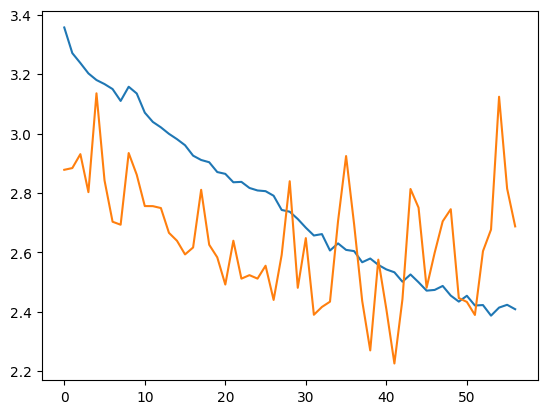

In [ ]:
plt.plot(train_loss_li)
plt.plot(val_loss_li)

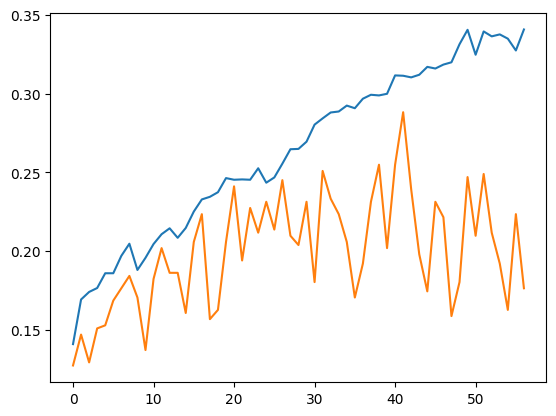

In [ ]:
plt.plot(train_acc_li)
plt.plot(val_acc_li)

## Mobile + Resnet

In [ ]:
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm

In [ ]:
import torch
import torch.nn as nn
from tqdm import tqdm
class DepthwiseSeparableConv(nn.Module):
  def __init__(self, in_dim, out_dim, stride=1):
      super(DepthwiseSeparableConv, self).__init__()
      self.depthwise = nn.Sequential(
        nn.Conv2d(in_dim, in_dim, kernel_size=3, stride=stride, padding=1, groups=in_dim, bias=False),
        nn.BatchNorm2d(in_dim),
        nn.ReLU6(),
        #nn.Dropout(0.1)
      )

      self.pointwise = nn.Sequential(
        nn.Conv2d(in_dim, out_dim, kernel_size=1, bias=False),
        nn.BatchNorm2d(out_dim),
        nn.ReLU6()
      )

  def forward(self, x):
    x = self.depthwise(x)
    x = self.pointwise(x)
    return x

class ResidualBlock(nn.Module):
  def __init__(self, in_dim, out_dim, stride=1):
    super(ResidualBlock, self).__init__()
    self.conv = DepthwiseSeparableConv(in_dim, out_dim, stride)
    self.downsample = (
      nn.Conv2d(in_dim, out_dim, kernel_size=1, stride=stride, bias=False)
      if in_dim != out_dim else None
    )
    self.bn = nn.BatchNorm2d(out_dim)  # BatchNorm for the downsampled identity

  def forward(self, x):
    identity = x
    x = self.conv(x)
    if self.downsample:
      identity = self.downsample(identity)
      identity = self.bn(identity) # Normalize downsampled
    return x + identity

class MobileResNet(nn.Module):
    def __init__(self, num_classes=50):
        super(MobileResNet, self).__init__()
        self.initial_conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.15)
        )
        self.layers = nn.Sequential(
            ResidualBlock(32, 64, stride=1),
            ResidualBlock(64, 128, stride=2),
            ResidualBlock(128, 128, stride=1),
            ResidualBlock(128, 256, stride=2),
            ResidualBlock(256, 256, stride=1),
            ResidualBlock(256, 512, stride=2),
            *[ResidualBlock(512, 512, stride=1) for _ in range(8)],  # Adjust depth
            ResidualBlock(512, 1024, stride=2),
            *[ResidualBlock(1024, 1024, stride=1) for _ in range(4)]  # Adjust depth
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),  # Dropout 0.5 recommended in paper
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        x = self.initial_conv(x)
        x = self.layers(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MobileResNet(50).to(device)

In [ ]:
import torch.optim as optim
from torch.optim import Adam

learning_rate = 0.0002
num_epochs = 100

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

mobres_ = MobileResNet(50).to(device)
optimizer = Adam(mobres_.parameters(), lr = learning_rate, weight_decay=0.0005)

cuda


In [ ]:
from tqdm import tqdm

"""
모델 돌리는 코드!!!!!!
돌리기 전에 주의
"""

# augmentation에 distortion 지우자

# weights and bias library 사용!

train_loss_li = []
train_acc_li = []
val_loss_li = []
val_acc_li = []
best_val_loss = float('inf')
best_val_acc = float('-inf')
best_model_loss = None
best_model_acc = None
cnt = 0

for epoch in tqdm(range(num_epochs)):
  train_loss, train_acc = train_loop(train_dataloader, model, loss_func, optimizer, device)
  val_loss, val_acc = validation_loop(val_dataloader, model, loss_func, device)
  train_loss_li.append(train_loss)
  train_acc_li.append(train_acc)
  val_loss_li.append(val_loss)
  val_acc_li.append(val_acc)

  if epoch % 1 == 0:
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

  # best model state 저장
  if val_acc > best_val_acc:
    best_val_acc = val_acc
    best_model_acc = model.state_dict()
    print("Best model updated : validation accuracy of {}".format(best_val_acc))
    cnt = 0
  else:
    cnt+=1
    if cnt == 15:
      print("----Early stopping----")
      break


  1%|          | 1/100 [00:36<1:00:48, 36.85s/it]

Epoch 1/100, Train Loss: 4.3020, Train Acc: 0.0789, Val Loss: 13.8193, Val Acc: 0.0392
Best model updated : validation accuracy of 0.0392156862745098


  2%|▏         | 2/100 [01:12<59:02, 36.15s/it]  

Epoch 2/100, Train Loss: 3.6580, Train Acc: 0.1408, Val Loss: 3.1818, Val Acc: 0.1137
Best model updated : validation accuracy of 0.11372549019607843


  3%|▎         | 3/100 [01:48<58:15, 36.04s/it]

Epoch 3/100, Train Loss: 3.2551, Train Acc: 0.1752, Val Loss: 3.0709, Val Acc: 0.1118


  4%|▍         | 4/100 [02:24<57:39, 36.04s/it]

Epoch 4/100, Train Loss: 3.0029, Train Acc: 0.2222, Val Loss: 2.8337, Val Acc: 0.1490
Best model updated : validation accuracy of 0.14901960784313725


  5%|▌         | 5/100 [03:00<57:09, 36.09s/it]

Epoch 5/100, Train Loss: 2.8940, Train Acc: 0.2497, Val Loss: 2.8922, Val Acc: 0.2039
Best model updated : validation accuracy of 0.20392156862745098


  6%|▌         | 6/100 [03:36<56:39, 36.16s/it]

Epoch 6/100, Train Loss: 2.7045, Train Acc: 0.2829, Val Loss: 2.7539, Val Acc: 0.2118
Best model updated : validation accuracy of 0.21176470588235294


  7%|▋         | 7/100 [04:13<56:09, 36.23s/it]

Epoch 7/100, Train Loss: 2.5364, Train Acc: 0.3201, Val Loss: 2.8478, Val Acc: 0.1980


  8%|▊         | 8/100 [04:49<55:34, 36.25s/it]

Epoch 8/100, Train Loss: 2.4682, Train Acc: 0.3328, Val Loss: 2.4149, Val Acc: 0.2431
Best model updated : validation accuracy of 0.24313725490196078


  9%|▉         | 9/100 [05:26<55:06, 36.34s/it]

Epoch 9/100, Train Loss: 2.3339, Train Acc: 0.3662, Val Loss: 2.5698, Val Acc: 0.2235


 10%|█         | 10/100 [06:02<54:34, 36.38s/it]

Epoch 10/100, Train Loss: 2.1993, Train Acc: 0.3785, Val Loss: 2.4653, Val Acc: 0.2255


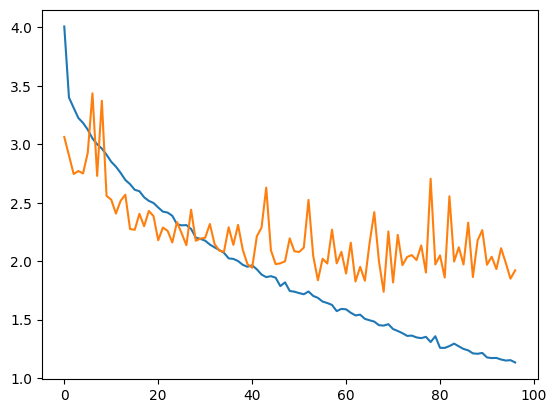

In [ ]:
plt.plot(train_loss_li)
plt.plot(val_loss_li)

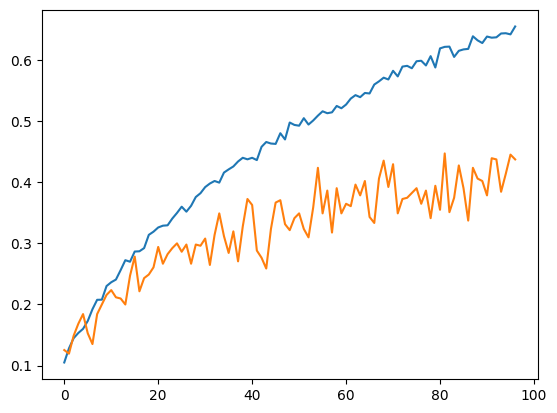

In [ ]:
plt.plot(train_acc_li)
plt.plot(val_acc_li)

# Saving result

In [ ]:
# checking data
test_data[0][0].shape

torch.Size([3, 224, 224])

In [ ]:
# Predict test classes
model.eval()

res = []
for i in range(len(test_data_)):
  data, path = test_data_[i]
  data = data.to(device).unsqueeze(0)
  output = model(data)
  predicted = torch.argmax(output, dim=1)
  artist = trainset.gt_string[predicted]
  res.append([path[-7:-4], artist])

In [ ]:
train_data.dataset.gt_string[25]

'Albrecht Du rer'

In [ ]:
result = pd.DataFrame(res, columns=['id', 'artist'])

In [ ]:
result.to_csv('result_model.csv', index=False)